## Feature Extraction Pipeline

In [1]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) 

# Remove the last layer to get the 2048-dim feature vector
model = nn.Sequential(*list(model.children())[:-1]) 
model = nn.DataParallel(model).to(device)
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4) 
features_dict = {}

# Extraction Loop
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1) 
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

# Save to pickle file
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

Found images at: /kaggle/input/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s] 
Extracting Features: 100%|██████████| 249/249 [02:02<00:00,  2.04it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


## Vocab & Text Pre Processing

In [50]:
import pandas as pd
import collections
import re
class Vocabulary:
    def __init__(self, freq_threshold):
        # Setting up the dictionary
        # <pad>: used for padding shorter sentences
        # <start>: tells the model to begin generating
        # <end>: tells the model to stop generating
        # <unk>: for words that appear less than the freq_threshold
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        # Basic cleaning: lowercase and remove non-alphabetic characters
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text.split()

    def build_vocabulary(self, sentence_list):
        frequencies = collections.Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] += 1

                # Only add word to vocab if it meets frequency requirement
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        # Convert a sentence into a list of numbers
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"] for token in tokenized_text]

In [51]:
# 1. Find and Load the data
def find_captions_path():
    for root, dirs, files in os.walk('/kaggle/input'):
        if 'captions.txt' in files:
            return os.path.join(root, 'captions.txt')
    return None

CAPTIONS_PATH = find_captions_path()

if CAPTIONS_PATH:
    df = pd.read_csv(CAPTIONS_PATH)
    # --- DATA CLEANING (The fix for the float error) ---
    # Force everything to string and drop empty rows
    df['caption'] = df['caption'].astype(str) 
    df = df.dropna(subset=['caption'])        
    
    print(f"Loaded {len(df)} captions.")

    # 2. Build the Vocabulary
    vocab = Vocabulary(freq_threshold=5)
    vocab.build_vocabulary(df['caption'].tolist())
    print(f"Size of vocabulary: {len(vocab)}")
else:
    print("Error: captions.txt not found. Make sure the dataset is attached.")

Loaded 158915 captions.
Size of vocabulary: 7727


In [52]:
# --- SAVE VOCABULARY IMMEDIATELY ---
import pickle
import os

# Make sure we save it to the working directory
vocab_path = "/kaggle/working/vocab.pkl"

if 'vocab' in globals():
    with open(vocab_path, "wb") as f:
        pickle.dump(vocab, f)
    print(f"Vocabulary saved to {vocab_path}")
else:
    print("Error: 'vocab' object not found. Please run the cell above where Vocabulary is built.")

Vocabulary saved to /kaggle/working/vocab.pkl


In [30]:
test_sentence = "A man is climbing a rock"
numerical = vocab.numericalize(test_sentence)
print(f"Test Sentence: {test_sentence}")
print(f"Numericalized: {numerical}")

Test Sentence: A man is climbing a rock
Numericalized: [5, 9, 15, 113, 5, 135]


## Encoder

In [41]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Use ResNet50, removing the last two layers (avgpool and fc)
        # to preserve spatial features for Attention (7x7 grid)
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Freezing the backbone (optional: unfreeze for fine-tuning later)
        for param in resnet.parameters():
            param.requires_grad = False
            
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # images: (batch_size, 3, 224, 224)
        features = self.resnet(images) # (batch, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1) # (batch, 7, 7, 2048)
        features = features.view(features.size(0), -1, features.size(3)) # (batch, 49, 2048)
        
        # Make sure gradient flow works
        return features

## Decoder

In [42]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)))
        alpha = self.softmax(att)
        context = (encoder_out * alpha).sum(dim=1)
        return context, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim=2048, attention_dim=256):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.attention = BahdanauAttention(encoder_dim, hidden_size, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.init_h = nn.Linear(encoder_dim, hidden_size)
        self.init_c = nn.Linear(encoder_dim, hidden_size)
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.f_beta = nn.Linear(hidden_size, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        
        seq_len = captions.size(1) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_len, num_features).to(device)
        
        for s in range(seq_len):
            context, alpha = self.attention(features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context
            
            lstm_input = torch.cat((embeddings[:, s, :], gated_context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            output = self.fc(self.dropout(h))
            preds[:, s, :] = output
            alphas[:, s, :] = alpha.squeeze(2)
            
        return preds, alphas

## Seq2Seq

In [43]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim=attention_dim)
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs, alphas = self.decoder(features, captions)
        return outputs, alphas

# Initialize Model
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
attention_dim = 256
learning_rate = 3e-4

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size, attention_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

## Training Loop

In [44]:
from torch.nn.utils.rnn import pad_sequence

class FlickrTrainDataset(Dataset):
    def __init__(self, df, root_dir, vocab, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.vocab = vocab
        self.transform = transform
        
        # Get img, caption columns
        self.imgs = df.iloc[:, 0]
        self.captions = df.iloc[:, 1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions.iloc[index]
        img_id = self.imgs.iloc[index]
        img_path = os.path.join(self.root_dir, img_id)
        
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
            
        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<end>"])
        
        return image, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

# Setup DataLoader
# Note: Reuse IMAGE_DIR and df from previous cells
train_dataset = FlickrTrainDataset(df, IMAGE_DIR, vocab, transform)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32, # Lower batch size for handling full images + ResNet
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    collate_fn=MyCollate(pad_idx=vocab.stoi["<pad>"])
)

# Training Loop
num_epochs = 10 # Adjust as needed
print_every = 100

for epoch in range(num_epochs):
    model.train()
    for idx, (imgs, captions) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(imgs, captions)
        
        # (batch, seq_len, vocab_size) -> (batch * seq_len, vocab_size)
        # targets: (batch, seq_len) -> (batch * seq_len)
        targets = captions[:, 1:] # Skip <start>
        outputs = outputs.reshape(-1, outputs.shape[2])
        targets = targets.reshape(-1)
        
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if idx % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), "best_model.pth")
    print(f"Epoch {epoch+1} saved.")

# Save vocab
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

Epoch 1/10:   0%|          | 2/4967 [00:01<44:25,  1.86it/s]  

Epoch [1/10], Step [0/4967], Loss: 8.9469


Epoch 1/10:   2%|▏         | 102/4967 [00:21<17:45,  4.57it/s]

Epoch [1/10], Step [100/4967], Loss: 5.2156


Epoch 1/10:   4%|▍         | 202/4967 [00:43<17:39,  4.50it/s]

Epoch [1/10], Step [200/4967], Loss: 4.9491


Epoch 1/10:   6%|▌         | 302/4967 [01:04<15:29,  5.02it/s]

Epoch [1/10], Step [300/4967], Loss: 4.3519


Epoch 1/10:   8%|▊         | 402/4967 [01:24<16:01,  4.75it/s]

Epoch [1/10], Step [400/4967], Loss: 4.5895


Epoch 1/10:  10%|█         | 502/4967 [01:45<15:45,  4.72it/s]

Epoch [1/10], Step [500/4967], Loss: 4.4697


Epoch 1/10:  12%|█▏        | 602/4967 [02:06<14:10,  5.13it/s]

Epoch [1/10], Step [600/4967], Loss: 4.3516


Epoch 1/10:  14%|█▍        | 702/4967 [02:26<14:00,  5.07it/s]

Epoch [1/10], Step [700/4967], Loss: 4.2483


Epoch 1/10:  16%|█▌        | 801/4967 [02:47<15:26,  4.50it/s]

Epoch [1/10], Step [800/4967], Loss: 4.0269


Epoch 1/10:  18%|█▊        | 902/4967 [03:08<14:31,  4.67it/s]

Epoch [1/10], Step [900/4967], Loss: 4.2755


Epoch 1/10:  20%|██        | 1002/4967 [03:28<13:34,  4.87it/s]

Epoch [1/10], Step [1000/4967], Loss: 3.7510


Epoch 1/10:  22%|██▏       | 1102/4967 [03:49<13:33,  4.75it/s]

Epoch [1/10], Step [1100/4967], Loss: 3.9028


Epoch 1/10:  24%|██▍       | 1202/4967 [04:10<13:59,  4.49it/s]

Epoch [1/10], Step [1200/4967], Loss: 3.9778


Epoch 1/10:  26%|██▌       | 1302/4967 [04:30<13:20,  4.58it/s]

Epoch [1/10], Step [1300/4967], Loss: 3.9128


Epoch 1/10:  28%|██▊       | 1402/4967 [04:52<14:21,  4.14it/s]

Epoch [1/10], Step [1400/4967], Loss: 4.2797


Epoch 1/10:  30%|███       | 1502/4967 [05:13<11:59,  4.82it/s]

Epoch [1/10], Step [1500/4967], Loss: 3.6648


Epoch 1/10:  32%|███▏      | 1602/4967 [05:33<11:44,  4.78it/s]

Epoch [1/10], Step [1600/4967], Loss: 4.2410


Epoch 1/10:  34%|███▍      | 1702/4967 [05:54<11:09,  4.88it/s]

Epoch [1/10], Step [1700/4967], Loss: 3.9703


Epoch 1/10:  36%|███▋      | 1802/4967 [06:15<10:26,  5.05it/s]

Epoch [1/10], Step [1800/4967], Loss: 3.8106


Epoch 1/10:  38%|███▊      | 1902/4967 [06:36<10:56,  4.67it/s]

Epoch [1/10], Step [1900/4967], Loss: 3.7078


Epoch 1/10:  40%|████      | 2002/4967 [06:56<10:19,  4.79it/s]

Epoch [1/10], Step [2000/4967], Loss: 3.7632


Epoch 1/10:  42%|████▏     | 2101/4967 [07:17<10:06,  4.73it/s]

Epoch [1/10], Step [2100/4967], Loss: 3.7537


Epoch 1/10:  44%|████▍     | 2202/4967 [07:38<09:51,  4.67it/s]

Epoch [1/10], Step [2200/4967], Loss: 3.6590


Epoch 1/10:  46%|████▋     | 2302/4967 [07:59<09:01,  4.92it/s]

Epoch [1/10], Step [2300/4967], Loss: 3.8248


Epoch 1/10:  48%|████▊     | 2402/4967 [08:20<08:11,  5.22it/s]

Epoch [1/10], Step [2400/4967], Loss: 3.5831


Epoch 1/10:  50%|█████     | 2501/4967 [08:41<08:45,  4.69it/s]

Epoch [1/10], Step [2500/4967], Loss: 3.5771


Epoch 1/10:  52%|█████▏    | 2602/4967 [09:02<08:08,  4.84it/s]

Epoch [1/10], Step [2600/4967], Loss: 3.9193


Epoch 1/10:  54%|█████▍    | 2702/4967 [09:22<07:51,  4.80it/s]

Epoch [1/10], Step [2700/4967], Loss: 3.5810


Epoch 1/10:  56%|█████▋    | 2802/4967 [09:43<07:30,  4.81it/s]

Epoch [1/10], Step [2800/4967], Loss: 3.7642


Epoch 1/10:  58%|█████▊    | 2902/4967 [10:04<06:35,  5.22it/s]

Epoch [1/10], Step [2900/4967], Loss: 3.9956


Epoch 1/10:  60%|██████    | 3002/4967 [10:25<06:23,  5.13it/s]

Epoch [1/10], Step [3000/4967], Loss: 3.3786


Epoch 1/10:  62%|██████▏   | 3102/4967 [10:45<06:32,  4.75it/s]

Epoch [1/10], Step [3100/4967], Loss: 3.6639


Epoch 1/10:  64%|██████▍   | 3202/4967 [11:06<06:04,  4.84it/s]

Epoch [1/10], Step [3200/4967], Loss: 3.6458


Epoch 1/10:  66%|██████▋   | 3302/4967 [11:27<05:44,  4.84it/s]

Epoch [1/10], Step [3300/4967], Loss: 3.4129


Epoch 1/10:  68%|██████▊   | 3402/4967 [11:48<05:12,  5.01it/s]

Epoch [1/10], Step [3400/4967], Loss: 3.5495


Epoch 1/10:  70%|███████   | 3501/4967 [12:08<05:14,  4.67it/s]

Epoch [1/10], Step [3500/4967], Loss: 3.6591


Epoch 1/10:  73%|███████▎  | 3602/4967 [12:29<04:47,  4.74it/s]

Epoch [1/10], Step [3600/4967], Loss: 3.3468


Epoch 1/10:  75%|███████▍  | 3702/4967 [12:50<04:28,  4.72it/s]

Epoch [1/10], Step [3700/4967], Loss: 3.1850


Epoch 1/10:  77%|███████▋  | 3802/4967 [13:11<04:08,  4.69it/s]

Epoch [1/10], Step [3800/4967], Loss: 3.8948


Epoch 1/10:  79%|███████▊  | 3902/4967 [13:32<03:30,  5.06it/s]

Epoch [1/10], Step [3900/4967], Loss: 3.5446


Epoch 1/10:  81%|████████  | 4002/4967 [13:53<03:07,  5.16it/s]

Epoch [1/10], Step [4000/4967], Loss: 3.3190


Epoch 1/10:  83%|████████▎ | 4102/4967 [14:13<02:39,  5.41it/s]

Epoch [1/10], Step [4100/4967], Loss: 3.1971


Epoch 1/10:  85%|████████▍ | 4202/4967 [14:34<02:41,  4.74it/s]

Epoch [1/10], Step [4200/4967], Loss: 3.5915


Epoch 1/10:  87%|████████▋ | 4302/4967 [14:55<02:17,  4.83it/s]

Epoch [1/10], Step [4300/4967], Loss: 3.2364


Epoch 1/10:  89%|████████▊ | 4402/4967 [15:16<02:01,  4.64it/s]

Epoch [1/10], Step [4400/4967], Loss: 3.4330


Epoch 1/10:  91%|█████████ | 4502/4967 [15:37<01:34,  4.92it/s]

Epoch [1/10], Step [4500/4967], Loss: 3.4984


Epoch 1/10:  93%|█████████▎| 4602/4967 [15:57<01:11,  5.08it/s]

Epoch [1/10], Step [4600/4967], Loss: 3.2552


Epoch 1/10:  95%|█████████▍| 4702/4967 [16:18<00:50,  5.29it/s]

Epoch [1/10], Step [4700/4967], Loss: 3.2555


Epoch 1/10:  97%|█████████▋| 4802/4967 [16:38<00:32,  5.04it/s]

Epoch [1/10], Step [4800/4967], Loss: 3.6621


Epoch 1/10:  99%|█████████▊| 4902/4967 [17:00<00:14,  4.61it/s]

Epoch [1/10], Step [4900/4967], Loss: 3.7421


Epoch 1 saved.


Epoch 2/10:   0%|          | 1/4967 [00:00<1:00:35,  1.37it/s]

Epoch [2/10], Step [0/4967], Loss: 3.1151


Epoch 2/10:   2%|▏         | 102/4967 [00:21<16:43,  4.85it/s]

Epoch [2/10], Step [100/4967], Loss: 3.6383


Epoch 2/10:   4%|▍         | 202/4967 [00:43<16:51,  4.71it/s]

Epoch [2/10], Step [200/4967], Loss: 3.0257


Epoch 2/10:   6%|▌         | 302/4967 [01:03<15:45,  4.94it/s]

Epoch [2/10], Step [300/4967], Loss: 3.2800


Epoch 2/10:   8%|▊         | 402/4967 [01:24<15:01,  5.07it/s]

Epoch [2/10], Step [400/4967], Loss: 3.2690


Epoch 2/10:  10%|█         | 502/4967 [01:45<15:04,  4.94it/s]

Epoch [2/10], Step [500/4967], Loss: 3.1167


Epoch 2/10:  12%|█▏        | 602/4967 [02:06<15:13,  4.78it/s]

Epoch [2/10], Step [600/4967], Loss: 3.4008


Epoch 2/10:  14%|█▍        | 702/4967 [02:26<14:33,  4.88it/s]

Epoch [2/10], Step [700/4967], Loss: 3.3759


Epoch 2/10:  16%|█▌        | 802/4967 [02:47<13:33,  5.12it/s]

Epoch [2/10], Step [800/4967], Loss: 3.2809


Epoch 2/10:  18%|█▊        | 902/4967 [03:08<13:47,  4.91it/s]

Epoch [2/10], Step [900/4967], Loss: 3.3075


Epoch 2/10:  20%|██        | 1002/4967 [03:29<12:40,  5.21it/s]

Epoch [2/10], Step [1000/4967], Loss: 3.0057


Epoch 2/10:  22%|██▏       | 1102/4967 [03:50<12:34,  5.12it/s]

Epoch [2/10], Step [1100/4967], Loss: 3.1019


Epoch 2/10:  24%|██▍       | 1202/4967 [04:10<12:15,  5.12it/s]

Epoch [2/10], Step [1200/4967], Loss: 3.5228


Epoch 2/10:  26%|██▌       | 1301/4967 [04:31<14:37,  4.18it/s]

Epoch [2/10], Step [1300/4967], Loss: 3.0684


Epoch 2/10:  28%|██▊       | 1402/4967 [04:52<11:49,  5.02it/s]

Epoch [2/10], Step [1400/4967], Loss: 3.3835


Epoch 2/10:  30%|███       | 1502/4967 [05:13<11:34,  4.99it/s]

Epoch [2/10], Step [1500/4967], Loss: 3.0394


Epoch 2/10:  32%|███▏      | 1602/4967 [05:34<11:51,  4.73it/s]

Epoch [2/10], Step [1600/4967], Loss: 3.2948


Epoch 2/10:  34%|███▍      | 1701/4967 [05:54<11:11,  4.86it/s]

Epoch [2/10], Step [1700/4967], Loss: 3.3603


Epoch 2/10:  36%|███▋      | 1801/4967 [06:14<11:13,  4.70it/s]

Epoch [2/10], Step [1800/4967], Loss: 3.0318


Epoch 2/10:  38%|███▊      | 1902/4967 [06:35<10:44,  4.76it/s]

Epoch [2/10], Step [1900/4967], Loss: 3.3704


Epoch 2/10:  40%|████      | 2002/4967 [06:56<10:41,  4.62it/s]

Epoch [2/10], Step [2000/4967], Loss: 3.1975


Epoch 2/10:  42%|████▏     | 2102/4967 [07:17<09:00,  5.30it/s]

Epoch [2/10], Step [2100/4967], Loss: 3.0162


Epoch 2/10:  44%|████▍     | 2202/4967 [07:37<09:12,  5.01it/s]

Epoch [2/10], Step [2200/4967], Loss: 3.3839


Epoch 2/10:  46%|████▋     | 2302/4967 [07:58<09:22,  4.74it/s]

Epoch [2/10], Step [2300/4967], Loss: 3.4843


Epoch 2/10:  48%|████▊     | 2402/4967 [08:18<08:02,  5.32it/s]

Epoch [2/10], Step [2400/4967], Loss: 3.2657


Epoch 2/10:  50%|█████     | 2502/4967 [08:39<08:13,  5.00it/s]

Epoch [2/10], Step [2500/4967], Loss: 3.3252


Epoch 2/10:  52%|█████▏    | 2602/4967 [09:00<08:00,  4.92it/s]

Epoch [2/10], Step [2600/4967], Loss: 3.3606


Epoch 2/10:  54%|█████▍    | 2702/4967 [09:21<07:41,  4.91it/s]

Epoch [2/10], Step [2700/4967], Loss: 3.2341


Epoch 2/10:  56%|█████▋    | 2802/4967 [09:41<07:08,  5.05it/s]

Epoch [2/10], Step [2800/4967], Loss: 3.1705


Epoch 2/10:  58%|█████▊    | 2901/4967 [10:02<07:01,  4.90it/s]

Epoch [2/10], Step [2900/4967], Loss: 3.2844


Epoch 2/10:  60%|██████    | 3002/4967 [10:23<06:32,  5.00it/s]

Epoch [2/10], Step [3000/4967], Loss: 2.9572


Epoch 2/10:  62%|██████▏   | 3102/4967 [10:44<06:28,  4.80it/s]

Epoch [2/10], Step [3100/4967], Loss: 3.0445


Epoch 2/10:  64%|██████▍   | 3202/4967 [11:05<05:59,  4.92it/s]

Epoch [2/10], Step [3200/4967], Loss: 3.1502


Epoch 2/10:  66%|██████▋   | 3302/4967 [11:25<05:36,  4.94it/s]

Epoch [2/10], Step [3300/4967], Loss: 3.2550


Epoch 2/10:  68%|██████▊   | 3402/4967 [11:46<05:12,  5.01it/s]

Epoch [2/10], Step [3400/4967], Loss: 3.1000


Epoch 2/10:  71%|███████   | 3502/4967 [12:07<04:55,  4.96it/s]

Epoch [2/10], Step [3500/4967], Loss: 3.0603


Epoch 2/10:  72%|███████▏  | 3601/4967 [12:28<05:00,  4.54it/s]

Epoch [2/10], Step [3600/4967], Loss: 3.2093


Epoch 2/10:  75%|███████▍  | 3702/4967 [12:49<04:04,  5.16it/s]

Epoch [2/10], Step [3700/4967], Loss: 3.0556


Epoch 2/10:  77%|███████▋  | 3802/4967 [13:10<04:02,  4.80it/s]

Epoch [2/10], Step [3800/4967], Loss: 3.4975


Epoch 2/10:  79%|███████▊  | 3902/4967 [13:30<03:41,  4.81it/s]

Epoch [2/10], Step [3900/4967], Loss: 3.0052


Epoch 2/10:  81%|████████  | 4002/4967 [13:51<03:19,  4.84it/s]

Epoch [2/10], Step [4000/4967], Loss: 2.9625


Epoch 2/10:  83%|████████▎ | 4101/4967 [14:11<02:55,  4.94it/s]

Epoch [2/10], Step [4100/4967], Loss: 3.1867


Epoch 2/10:  85%|████████▍ | 4201/4967 [14:32<02:49,  4.53it/s]

Epoch [2/10], Step [4200/4967], Loss: 3.1460


Epoch 2/10:  87%|████████▋ | 4302/4967 [14:53<02:14,  4.96it/s]

Epoch [2/10], Step [4300/4967], Loss: 3.0795


Epoch 2/10:  89%|████████▊ | 4401/4967 [15:14<01:57,  4.83it/s]

Epoch [2/10], Step [4400/4967], Loss: 3.1368


Epoch 2/10:  91%|█████████ | 4502/4967 [15:35<01:34,  4.93it/s]

Epoch [2/10], Step [4500/4967], Loss: 3.0133


Epoch 2/10:  93%|█████████▎| 4602/4967 [15:55<01:11,  5.10it/s]

Epoch [2/10], Step [4600/4967], Loss: 3.1332


Epoch 2/10:  95%|█████████▍| 4702/4967 [16:16<00:54,  4.89it/s]

Epoch [2/10], Step [4700/4967], Loss: 3.2493


Epoch 2/10:  97%|█████████▋| 4802/4967 [16:37<00:33,  4.93it/s]

Epoch [2/10], Step [4800/4967], Loss: 2.9165


Epoch 2/10:  99%|█████████▊| 4902/4967 [16:58<00:12,  5.17it/s]

Epoch [2/10], Step [4900/4967], Loss: 2.8064


Epoch 2 saved.


Epoch 3/10:   0%|          | 2/4967 [00:00<33:05,  2.50it/s]

Epoch [3/10], Step [0/4967], Loss: 2.8881


Epoch 3/10:   2%|▏         | 102/4967 [00:22<16:30,  4.91it/s]

Epoch [3/10], Step [100/4967], Loss: 3.0050


Epoch 3/10:   4%|▍         | 202/4967 [00:42<15:51,  5.01it/s]

Epoch [3/10], Step [200/4967], Loss: 3.0250


Epoch 3/10:   6%|▌         | 302/4967 [01:03<15:48,  4.92it/s]

Epoch [3/10], Step [300/4967], Loss: 3.0914


Epoch 3/10:   8%|▊         | 402/4967 [01:23<14:37,  5.20it/s]

Epoch [3/10], Step [400/4967], Loss: 3.0034


Epoch 3/10:  10%|█         | 502/4967 [01:44<15:49,  4.70it/s]

Epoch [3/10], Step [500/4967], Loss: 2.9313


Epoch 3/10:  12%|█▏        | 602/4967 [02:05<14:53,  4.88it/s]

Epoch [3/10], Step [600/4967], Loss: 3.4829


Epoch 3/10:  14%|█▍        | 702/4967 [02:25<13:58,  5.09it/s]

Epoch [3/10], Step [700/4967], Loss: 3.1801


Epoch 3/10:  16%|█▌        | 802/4967 [02:46<14:08,  4.91it/s]

Epoch [3/10], Step [800/4967], Loss: 3.0223


Epoch 3/10:  18%|█▊        | 902/4967 [03:07<13:55,  4.87it/s]

Epoch [3/10], Step [900/4967], Loss: 3.1695


Epoch 3/10:  20%|██        | 1002/4967 [03:28<13:57,  4.74it/s]

Epoch [3/10], Step [1000/4967], Loss: 2.8865


Epoch 3/10:  22%|██▏       | 1102/4967 [03:49<12:52,  5.00it/s]

Epoch [3/10], Step [1100/4967], Loss: 3.3578


Epoch 3/10:  24%|██▍       | 1202/4967 [04:10<12:16,  5.11it/s]

Epoch [3/10], Step [1200/4967], Loss: 2.9840


Epoch 3/10:  26%|██▌       | 1302/4967 [04:31<11:29,  5.32it/s]

Epoch [3/10], Step [1300/4967], Loss: 2.9487


Epoch 3/10:  28%|██▊       | 1402/4967 [04:51<12:49,  4.63it/s]

Epoch [3/10], Step [1400/4967], Loss: 3.2949


Epoch 3/10:  30%|███       | 1502/4967 [05:13<11:54,  4.85it/s]

Epoch [3/10], Step [1500/4967], Loss: 3.1074


Epoch 3/10:  32%|███▏      | 1602/4967 [05:34<12:00,  4.67it/s]

Epoch [3/10], Step [1600/4967], Loss: 2.8611


Epoch 3/10:  34%|███▍      | 1702/4967 [05:54<11:03,  4.92it/s]

Epoch [3/10], Step [1700/4967], Loss: 3.0243


Epoch 3/10:  36%|███▋      | 1802/4967 [06:15<10:46,  4.89it/s]

Epoch [3/10], Step [1800/4967], Loss: 2.7133


Epoch 3/10:  38%|███▊      | 1902/4967 [06:37<10:36,  4.81it/s]

Epoch [3/10], Step [1900/4967], Loss: 3.0531


Epoch 3/10:  40%|████      | 2002/4967 [06:57<10:09,  4.86it/s]

Epoch [3/10], Step [2000/4967], Loss: 2.8516


Epoch 3/10:  42%|████▏     | 2102/4967 [07:18<09:36,  4.97it/s]

Epoch [3/10], Step [2100/4967], Loss: 3.2065


Epoch 3/10:  44%|████▍     | 2202/4967 [07:39<09:11,  5.01it/s]

Epoch [3/10], Step [2200/4967], Loss: 2.8144


Epoch 3/10:  46%|████▋     | 2302/4967 [08:00<09:01,  4.93it/s]

Epoch [3/10], Step [2300/4967], Loss: 3.2539


Epoch 3/10:  48%|████▊     | 2402/4967 [08:20<09:07,  4.68it/s]

Epoch [3/10], Step [2400/4967], Loss: 3.1923


Epoch 3/10:  50%|█████     | 2501/4967 [08:41<08:13,  5.00it/s]

Epoch [3/10], Step [2500/4967], Loss: 2.8331


Epoch 3/10:  52%|█████▏    | 2602/4967 [09:01<07:37,  5.17it/s]

Epoch [3/10], Step [2600/4967], Loss: 2.8070


Epoch 3/10:  54%|█████▍    | 2702/4967 [09:22<07:24,  5.09it/s]

Epoch [3/10], Step [2700/4967], Loss: 3.0903


Epoch 3/10:  56%|█████▋    | 2802/4967 [09:43<07:07,  5.06it/s]

Epoch [3/10], Step [2800/4967], Loss: 2.8880


Epoch 3/10:  58%|█████▊    | 2902/4967 [10:04<06:43,  5.11it/s]

Epoch [3/10], Step [2900/4967], Loss: 2.7076


Epoch 3/10:  60%|██████    | 3002/4967 [10:25<06:32,  5.00it/s]

Epoch [3/10], Step [3000/4967], Loss: 2.7195


Epoch 3/10:  62%|██████▏   | 3102/4967 [10:45<06:10,  5.03it/s]

Epoch [3/10], Step [3100/4967], Loss: 2.9306


Epoch 3/10:  64%|██████▍   | 3202/4967 [11:06<05:47,  5.08it/s]

Epoch [3/10], Step [3200/4967], Loss: 3.0440


Epoch 3/10:  66%|██████▋   | 3302/4967 [11:27<05:11,  5.34it/s]

Epoch [3/10], Step [3300/4967], Loss: 2.7879


Epoch 3/10:  68%|██████▊   | 3402/4967 [11:48<05:01,  5.19it/s]

Epoch [3/10], Step [3400/4967], Loss: 2.7915


Epoch 3/10:  71%|███████   | 3502/4967 [12:08<05:29,  4.45it/s]

Epoch [3/10], Step [3500/4967], Loss: 2.8644


Epoch 3/10:  73%|███████▎  | 3602/4967 [12:29<04:39,  4.89it/s]

Epoch [3/10], Step [3600/4967], Loss: 3.1891


Epoch 3/10:  75%|███████▍  | 3702/4967 [12:49<04:00,  5.26it/s]

Epoch [3/10], Step [3700/4967], Loss: 3.1216


Epoch 3/10:  77%|███████▋  | 3802/4967 [13:10<04:03,  4.78it/s]

Epoch [3/10], Step [3800/4967], Loss: 3.1585


Epoch 3/10:  79%|███████▊  | 3901/4967 [13:30<03:41,  4.81it/s]

Epoch [3/10], Step [3900/4967], Loss: 3.1523


Epoch 3/10:  81%|████████  | 4001/4967 [13:51<03:14,  4.98it/s]

Epoch [3/10], Step [4000/4967], Loss: 2.9076


Epoch 3/10:  83%|████████▎ | 4102/4967 [14:12<02:58,  4.85it/s]

Epoch [3/10], Step [4100/4967], Loss: 3.0953


Epoch 3/10:  85%|████████▍ | 4202/4967 [14:33<02:43,  4.68it/s]

Epoch [3/10], Step [4200/4967], Loss: 3.0629


Epoch 3/10:  87%|████████▋ | 4302/4967 [14:54<02:13,  4.96it/s]

Epoch [3/10], Step [4300/4967], Loss: 3.0663


Epoch 3/10:  89%|████████▊ | 4402/4967 [15:15<01:55,  4.88it/s]

Epoch [3/10], Step [4400/4967], Loss: 2.9304


Epoch 3/10:  91%|█████████ | 4502/4967 [15:35<01:32,  5.05it/s]

Epoch [3/10], Step [4500/4967], Loss: 3.0534


Epoch 3/10:  93%|█████████▎| 4602/4967 [15:56<01:14,  4.91it/s]

Epoch [3/10], Step [4600/4967], Loss: 3.2667


Epoch 3/10:  95%|█████████▍| 4702/4967 [16:17<00:49,  5.33it/s]

Epoch [3/10], Step [4700/4967], Loss: 2.8593


Epoch 3/10:  97%|█████████▋| 4802/4967 [16:38<00:33,  4.97it/s]

Epoch [3/10], Step [4800/4967], Loss: 2.8731


Epoch 3/10:  99%|█████████▊| 4902/4967 [16:59<00:12,  5.21it/s]

Epoch [3/10], Step [4900/4967], Loss: 2.7847


Epoch 3 saved.


Epoch 4/10:   0%|          | 1/4967 [00:00<49:19,  1.68it/s]

Epoch [4/10], Step [0/4967], Loss: 2.6335


Epoch 4/10:   2%|▏         | 102/4967 [00:21<16:15,  4.99it/s]

Epoch [4/10], Step [100/4967], Loss: 2.9748


Epoch 4/10:   4%|▍         | 202/4967 [00:41<15:30,  5.12it/s]

Epoch [4/10], Step [200/4967], Loss: 3.0080


Epoch 4/10:   6%|▌         | 302/4967 [01:02<16:23,  4.74it/s]

Epoch [4/10], Step [300/4967], Loss: 2.7730


Epoch 4/10:   8%|▊         | 402/4967 [01:23<15:00,  5.07it/s]

Epoch [4/10], Step [400/4967], Loss: 2.6336


Epoch 4/10:  10%|█         | 502/4967 [01:44<14:31,  5.13it/s]

Epoch [4/10], Step [500/4967], Loss: 2.7834


Epoch 4/10:  12%|█▏        | 602/4967 [02:04<14:50,  4.90it/s]

Epoch [4/10], Step [600/4967], Loss: 2.8850


Epoch 4/10:  14%|█▍        | 701/4967 [02:25<15:01,  4.73it/s]

Epoch [4/10], Step [700/4967], Loss: 3.0861


Epoch 4/10:  16%|█▌        | 802/4967 [02:46<13:23,  5.19it/s]

Epoch [4/10], Step [800/4967], Loss: 2.9306


Epoch 4/10:  18%|█▊        | 901/4967 [03:07<14:47,  4.58it/s]

Epoch [4/10], Step [900/4967], Loss: 3.0028


Epoch 4/10:  20%|██        | 1002/4967 [03:28<14:16,  4.63it/s]

Epoch [4/10], Step [1000/4967], Loss: 3.0889


Epoch 4/10:  22%|██▏       | 1102/4967 [03:49<13:39,  4.72it/s]

Epoch [4/10], Step [1100/4967], Loss: 2.6009


Epoch 4/10:  24%|██▍       | 1202/4967 [04:10<13:29,  4.65it/s]

Epoch [4/10], Step [1200/4967], Loss: 3.4865


Epoch 4/10:  26%|██▌       | 1302/4967 [04:31<12:39,  4.82it/s]

Epoch [4/10], Step [1300/4967], Loss: 2.5270


Epoch 4/10:  28%|██▊       | 1402/4967 [04:51<12:10,  4.88it/s]

Epoch [4/10], Step [1400/4967], Loss: 2.8577


Epoch 4/10:  30%|███       | 1501/4967 [05:12<12:58,  4.45it/s]

Epoch [4/10], Step [1500/4967], Loss: 2.9401


Epoch 4/10:  32%|███▏      | 1601/4967 [05:33<12:03,  4.65it/s]

Epoch [4/10], Step [1600/4967], Loss: 2.8165


Epoch 4/10:  34%|███▍      | 1702/4967 [05:54<10:44,  5.06it/s]

Epoch [4/10], Step [1700/4967], Loss: 2.7079


Epoch 4/10:  36%|███▋      | 1801/4967 [06:14<12:13,  4.32it/s]

Epoch [4/10], Step [1800/4967], Loss: 2.8866


Epoch 4/10:  38%|███▊      | 1902/4967 [06:35<10:42,  4.77it/s]

Epoch [4/10], Step [1900/4967], Loss: 2.9236


Epoch 4/10:  40%|████      | 2002/4967 [06:56<10:23,  4.76it/s]

Epoch [4/10], Step [2000/4967], Loss: 2.5670


Epoch 4/10:  42%|████▏     | 2102/4967 [07:17<09:46,  4.89it/s]

Epoch [4/10], Step [2100/4967], Loss: 2.9382


Epoch 4/10:  44%|████▍     | 2202/4967 [07:37<10:01,  4.59it/s]

Epoch [4/10], Step [2200/4967], Loss: 2.7079


Epoch 4/10:  46%|████▋     | 2302/4967 [07:58<09:09,  4.85it/s]

Epoch [4/10], Step [2300/4967], Loss: 2.9652


Epoch 4/10:  48%|████▊     | 2402/4967 [08:19<08:26,  5.06it/s]

Epoch [4/10], Step [2400/4967], Loss: 2.7612


Epoch 4/10:  50%|█████     | 2502/4967 [08:39<08:55,  4.60it/s]

Epoch [4/10], Step [2500/4967], Loss: 2.8925


Epoch 4/10:  52%|█████▏    | 2602/4967 [09:00<08:27,  4.66it/s]

Epoch [4/10], Step [2600/4967], Loss: 2.9161


Epoch 4/10:  54%|█████▍    | 2702/4967 [09:21<07:27,  5.06it/s]

Epoch [4/10], Step [2700/4967], Loss: 3.0309


Epoch 4/10:  56%|█████▋    | 2802/4967 [09:42<07:24,  4.87it/s]

Epoch [4/10], Step [2800/4967], Loss: 2.7546


Epoch 4/10:  58%|█████▊    | 2902/4967 [10:02<07:11,  4.78it/s]

Epoch [4/10], Step [2900/4967], Loss: 2.9822


Epoch 4/10:  60%|██████    | 3002/4967 [10:23<06:25,  5.10it/s]

Epoch [4/10], Step [3000/4967], Loss: 2.7298


Epoch 4/10:  62%|██████▏   | 3102/4967 [10:44<06:34,  4.72it/s]

Epoch [4/10], Step [3100/4967], Loss: 3.1476


Epoch 4/10:  64%|██████▍   | 3202/4967 [11:05<06:31,  4.50it/s]

Epoch [4/10], Step [3200/4967], Loss: 2.9753


Epoch 4/10:  66%|██████▋   | 3302/4967 [11:25<05:22,  5.16it/s]

Epoch [4/10], Step [3300/4967], Loss: 2.6995


Epoch 4/10:  68%|██████▊   | 3402/4967 [11:46<05:42,  4.57it/s]

Epoch [4/10], Step [3400/4967], Loss: 3.0772


Epoch 4/10:  71%|███████   | 3502/4967 [12:07<04:47,  5.09it/s]

Epoch [4/10], Step [3500/4967], Loss: 3.2327


Epoch 4/10:  72%|███████▏  | 3601/4967 [12:27<04:46,  4.76it/s]

Epoch [4/10], Step [3600/4967], Loss: 2.5110


Epoch 4/10:  75%|███████▍  | 3702/4967 [12:48<04:35,  4.59it/s]

Epoch [4/10], Step [3700/4967], Loss: 2.8505


Epoch 4/10:  77%|███████▋  | 3802/4967 [13:09<04:12,  4.61it/s]

Epoch [4/10], Step [3800/4967], Loss: 2.8845


Epoch 4/10:  79%|███████▊  | 3901/4967 [13:30<03:42,  4.78it/s]

Epoch [4/10], Step [3900/4967], Loss: 2.8308


Epoch 4/10:  81%|████████  | 4002/4967 [13:51<03:07,  5.14it/s]

Epoch [4/10], Step [4000/4967], Loss: 2.7817


Epoch 4/10:  83%|████████▎ | 4102/4967 [14:12<02:58,  4.85it/s]

Epoch [4/10], Step [4100/4967], Loss: 2.9159


Epoch 4/10:  85%|████████▍ | 4202/4967 [14:33<02:31,  5.04it/s]

Epoch [4/10], Step [4200/4967], Loss: 2.9554


Epoch 4/10:  87%|████████▋ | 4302/4967 [14:54<02:25,  4.56it/s]

Epoch [4/10], Step [4300/4967], Loss: 2.6802


Epoch 4/10:  89%|████████▊ | 4402/4967 [15:15<01:50,  5.09it/s]

Epoch [4/10], Step [4400/4967], Loss: 2.6612


Epoch 4/10:  91%|█████████ | 4502/4967 [15:35<01:33,  4.99it/s]

Epoch [4/10], Step [4500/4967], Loss: 2.7651


Epoch 4/10:  93%|█████████▎| 4602/4967 [15:56<01:16,  4.78it/s]

Epoch [4/10], Step [4600/4967], Loss: 2.8538


Epoch 4/10:  95%|█████████▍| 4702/4967 [16:18<00:58,  4.52it/s]

Epoch [4/10], Step [4700/4967], Loss: 2.8701


Epoch 4/10:  97%|█████████▋| 4802/4967 [16:38<00:32,  5.13it/s]

Epoch [4/10], Step [4800/4967], Loss: 2.7441


Epoch 4/10:  99%|█████████▊| 4902/4967 [16:59<00:13,  4.96it/s]

Epoch [4/10], Step [4900/4967], Loss: 2.8327


Epoch 4 saved.


Epoch 5/10:   0%|          | 1/4967 [00:00<49:27,  1.67it/s]

Epoch [5/10], Step [0/4967], Loss: 2.6555


Epoch 5/10:   2%|▏         | 102/4967 [00:21<16:23,  4.95it/s]

Epoch [5/10], Step [100/4967], Loss: 2.7332


Epoch 5/10:   4%|▍         | 202/4967 [00:41<16:13,  4.90it/s]

Epoch [5/10], Step [200/4967], Loss: 2.6671


Epoch 5/10:   6%|▌         | 302/4967 [01:02<15:56,  4.88it/s]

Epoch [5/10], Step [300/4967], Loss: 2.9417


Epoch 5/10:   8%|▊         | 402/4967 [01:23<14:39,  5.19it/s]

Epoch [5/10], Step [400/4967], Loss: 2.8366


Epoch 5/10:  10%|█         | 502/4967 [01:44<14:10,  5.25it/s]

Epoch [5/10], Step [500/4967], Loss: 2.9855


Epoch 5/10:  12%|█▏        | 602/4967 [02:05<14:56,  4.87it/s]

Epoch [5/10], Step [600/4967], Loss: 2.8998


Epoch 5/10:  14%|█▍        | 702/4967 [02:26<15:04,  4.72it/s]

Epoch [5/10], Step [700/4967], Loss: 2.7434


Epoch 5/10:  16%|█▌        | 802/4967 [02:46<14:29,  4.79it/s]

Epoch [5/10], Step [800/4967], Loss: 2.8034


Epoch 5/10:  18%|█▊        | 901/4967 [03:07<14:13,  4.76it/s]

Epoch [5/10], Step [900/4967], Loss: 2.7932


Epoch 5/10:  20%|██        | 1002/4967 [03:28<13:06,  5.04it/s]

Epoch [5/10], Step [1000/4967], Loss: 2.7259


Epoch 5/10:  22%|██▏       | 1102/4967 [03:49<12:11,  5.28it/s]

Epoch [5/10], Step [1100/4967], Loss: 2.8364


Epoch 5/10:  24%|██▍       | 1202/4967 [04:10<13:23,  4.69it/s]

Epoch [5/10], Step [1200/4967], Loss: 2.8737


Epoch 5/10:  26%|██▌       | 1301/4967 [04:30<13:01,  4.69it/s]

Epoch [5/10], Step [1300/4967], Loss: 2.8089


Epoch 5/10:  28%|██▊       | 1402/4967 [04:51<11:45,  5.05it/s]

Epoch [5/10], Step [1400/4967], Loss: 2.6506


Epoch 5/10:  30%|███       | 1501/4967 [05:12<11:57,  4.83it/s]

Epoch [5/10], Step [1500/4967], Loss: 2.7164


Epoch 5/10:  32%|███▏      | 1602/4967 [05:33<11:17,  4.97it/s]

Epoch [5/10], Step [1600/4967], Loss: 2.6817


Epoch 5/10:  34%|███▍      | 1702/4967 [05:54<11:03,  4.92it/s]

Epoch [5/10], Step [1700/4967], Loss: 2.8600


Epoch 5/10:  36%|███▋      | 1801/4967 [06:15<12:27,  4.23it/s]

Epoch [5/10], Step [1800/4967], Loss: 3.1478


Epoch 5/10:  38%|███▊      | 1902/4967 [06:36<09:58,  5.12it/s]

Epoch [5/10], Step [1900/4967], Loss: 2.7635


Epoch 5/10:  40%|████      | 2002/4967 [06:57<09:42,  5.09it/s]

Epoch [5/10], Step [2000/4967], Loss: 2.9205


Epoch 5/10:  42%|████▏     | 2102/4967 [07:18<10:01,  4.77it/s]

Epoch [5/10], Step [2100/4967], Loss: 2.8976


Epoch 5/10:  44%|████▍     | 2201/4967 [07:38<09:58,  4.62it/s]

Epoch [5/10], Step [2200/4967], Loss: 2.6474


Epoch 5/10:  46%|████▋     | 2302/4967 [07:59<08:55,  4.98it/s]

Epoch [5/10], Step [2300/4967], Loss: 2.8640


Epoch 5/10:  48%|████▊     | 2402/4967 [08:20<08:12,  5.21it/s]

Epoch [5/10], Step [2400/4967], Loss: 2.5623


Epoch 5/10:  50%|█████     | 2502/4967 [08:40<08:25,  4.88it/s]

Epoch [5/10], Step [2500/4967], Loss: 2.3807


Epoch 5/10:  52%|█████▏    | 2601/4967 [09:01<08:07,  4.86it/s]

Epoch [5/10], Step [2600/4967], Loss: 2.7778


Epoch 5/10:  54%|█████▍    | 2702/4967 [09:23<08:21,  4.51it/s]

Epoch [5/10], Step [2700/4967], Loss: 2.8717


Epoch 5/10:  56%|█████▋    | 2802/4967 [09:43<07:13,  4.99it/s]

Epoch [5/10], Step [2800/4967], Loss: 2.8431


Epoch 5/10:  58%|█████▊    | 2902/4967 [10:04<06:56,  4.96it/s]

Epoch [5/10], Step [2900/4967], Loss: 2.7385


Epoch 5/10:  60%|██████    | 3002/4967 [10:25<06:11,  5.30it/s]

Epoch [5/10], Step [3000/4967], Loss: 3.1108


Epoch 5/10:  62%|██████▏   | 3102/4967 [10:46<06:09,  5.04it/s]

Epoch [5/10], Step [3100/4967], Loss: 2.7039


Epoch 5/10:  64%|██████▍   | 3202/4967 [11:07<05:48,  5.07it/s]

Epoch [5/10], Step [3200/4967], Loss: 2.8898


Epoch 5/10:  66%|██████▋   | 3302/4967 [11:28<06:06,  4.54it/s]

Epoch [5/10], Step [3300/4967], Loss: 2.4848


Epoch 5/10:  68%|██████▊   | 3401/4967 [11:48<05:30,  4.73it/s]

Epoch [5/10], Step [3400/4967], Loss: 2.5768


Epoch 5/10:  71%|███████   | 3502/4967 [12:09<04:47,  5.09it/s]

Epoch [5/10], Step [3500/4967], Loss: 2.7829


Epoch 5/10:  73%|███████▎  | 3602/4967 [12:30<04:47,  4.75it/s]

Epoch [5/10], Step [3600/4967], Loss: 2.9777


Epoch 5/10:  75%|███████▍  | 3702/4967 [12:51<04:20,  4.85it/s]

Epoch [5/10], Step [3700/4967], Loss: 2.8514


Epoch 5/10:  77%|███████▋  | 3802/4967 [13:11<03:45,  5.17it/s]

Epoch [5/10], Step [3800/4967], Loss: 2.8796


Epoch 5/10:  79%|███████▊  | 3902/4967 [13:32<03:39,  4.85it/s]

Epoch [5/10], Step [3900/4967], Loss: 2.8570


Epoch 5/10:  81%|████████  | 4002/4967 [13:52<03:14,  4.97it/s]

Epoch [5/10], Step [4000/4967], Loss: 2.4717


Epoch 5/10:  83%|████████▎ | 4102/4967 [14:13<03:01,  4.77it/s]

Epoch [5/10], Step [4100/4967], Loss: 2.9921


Epoch 5/10:  85%|████████▍ | 4201/4967 [14:34<02:31,  5.05it/s]

Epoch [5/10], Step [4200/4967], Loss: 2.5657


Epoch 5/10:  87%|████████▋ | 4302/4967 [14:55<02:14,  4.94it/s]

Epoch [5/10], Step [4300/4967], Loss: 2.6914


Epoch 5/10:  89%|████████▊ | 4402/4967 [15:15<01:52,  5.02it/s]

Epoch [5/10], Step [4400/4967], Loss: 2.5644


Epoch 5/10:  91%|█████████ | 4501/4967 [15:36<01:38,  4.73it/s]

Epoch [5/10], Step [4500/4967], Loss: 2.8564


Epoch 5/10:  93%|█████████▎| 4602/4967 [15:57<01:14,  4.87it/s]

Epoch [5/10], Step [4600/4967], Loss: 2.5772


Epoch 5/10:  95%|█████████▍| 4701/4967 [16:17<00:56,  4.71it/s]

Epoch [5/10], Step [4700/4967], Loss: 2.7626


Epoch 5/10:  97%|█████████▋| 4802/4967 [16:38<00:34,  4.76it/s]

Epoch [5/10], Step [4800/4967], Loss: 2.7879


Epoch 5/10:  99%|█████████▊| 4902/4967 [16:59<00:13,  4.96it/s]

Epoch [5/10], Step [4900/4967], Loss: 2.4563


Epoch 5 saved.


Epoch 6/10:   0%|          | 2/4967 [00:00<29:21,  2.82it/s]

Epoch [6/10], Step [0/4967], Loss: 2.8238


Epoch 6/10:   2%|▏         | 101/4967 [00:21<17:32,  4.62it/s]

Epoch [6/10], Step [100/4967], Loss: 2.5421


Epoch 6/10:   4%|▍         | 202/4967 [00:42<16:30,  4.81it/s]

Epoch [6/10], Step [200/4967], Loss: 2.9555


Epoch 6/10:   6%|▌         | 302/4967 [01:02<15:52,  4.90it/s]

Epoch [6/10], Step [300/4967], Loss: 2.5649


Epoch 6/10:   8%|▊         | 402/4967 [01:23<15:01,  5.07it/s]

Epoch [6/10], Step [400/4967], Loss: 2.8646


Epoch 6/10:  10%|█         | 502/4967 [01:44<15:29,  4.80it/s]

Epoch [6/10], Step [500/4967], Loss: 2.6785


Epoch 6/10:  12%|█▏        | 602/4967 [02:05<14:19,  5.08it/s]

Epoch [6/10], Step [600/4967], Loss: 2.7698


Epoch 6/10:  14%|█▍        | 702/4967 [02:26<14:07,  5.03it/s]

Epoch [6/10], Step [700/4967], Loss: 2.9063


Epoch 6/10:  16%|█▌        | 802/4967 [02:46<14:37,  4.74it/s]

Epoch [6/10], Step [800/4967], Loss: 2.6408


Epoch 6/10:  18%|█▊        | 902/4967 [03:07<15:16,  4.44it/s]

Epoch [6/10], Step [900/4967], Loss: 2.7618


Epoch 6/10:  20%|██        | 1002/4967 [03:27<13:56,  4.74it/s]

Epoch [6/10], Step [1000/4967], Loss: 2.7335


Epoch 6/10:  22%|██▏       | 1102/4967 [03:48<12:28,  5.17it/s]

Epoch [6/10], Step [1100/4967], Loss: 2.4538


Epoch 6/10:  24%|██▍       | 1202/4967 [04:08<12:16,  5.11it/s]

Epoch [6/10], Step [1200/4967], Loss: 2.4626


Epoch 6/10:  26%|██▌       | 1302/4967 [04:29<12:02,  5.07it/s]

Epoch [6/10], Step [1300/4967], Loss: 2.5947


Epoch 6/10:  28%|██▊       | 1401/4967 [04:49<12:59,  4.58it/s]

Epoch [6/10], Step [1400/4967], Loss: 2.8177


Epoch 6/10:  30%|███       | 1502/4967 [05:11<12:09,  4.75it/s]

Epoch [6/10], Step [1500/4967], Loss: 2.4387


Epoch 6/10:  32%|███▏      | 1602/4967 [05:32<12:37,  4.44it/s]

Epoch [6/10], Step [1600/4967], Loss: 2.7808


Epoch 6/10:  34%|███▍      | 1702/4967 [05:52<10:59,  4.95it/s]

Epoch [6/10], Step [1700/4967], Loss: 2.5365


Epoch 6/10:  36%|███▋      | 1802/4967 [06:14<10:58,  4.81it/s]

Epoch [6/10], Step [1800/4967], Loss: 2.6220


Epoch 6/10:  38%|███▊      | 1902/4967 [06:34<10:16,  4.97it/s]

Epoch [6/10], Step [1900/4967], Loss: 2.5423


Epoch 6/10:  40%|████      | 2002/4967 [06:55<09:32,  5.18it/s]

Epoch [6/10], Step [2000/4967], Loss: 2.5855


Epoch 6/10:  42%|████▏     | 2102/4967 [07:16<10:02,  4.76it/s]

Epoch [6/10], Step [2100/4967], Loss: 2.5633


Epoch 6/10:  44%|████▍     | 2202/4967 [07:36<08:55,  5.16it/s]

Epoch [6/10], Step [2200/4967], Loss: 2.6296


Epoch 6/10:  46%|████▋     | 2302/4967 [07:57<09:27,  4.70it/s]

Epoch [6/10], Step [2300/4967], Loss: 2.8668


Epoch 6/10:  48%|████▊     | 2402/4967 [08:18<09:09,  4.67it/s]

Epoch [6/10], Step [2400/4967], Loss: 2.6911


Epoch 6/10:  50%|█████     | 2502/4967 [08:39<08:20,  4.93it/s]

Epoch [6/10], Step [2500/4967], Loss: 2.7377


Epoch 6/10:  52%|█████▏    | 2601/4967 [08:59<08:18,  4.74it/s]

Epoch [6/10], Step [2600/4967], Loss: 2.7912


Epoch 6/10:  54%|█████▍    | 2702/4967 [09:20<07:30,  5.03it/s]

Epoch [6/10], Step [2700/4967], Loss: 2.6930


Epoch 6/10:  56%|█████▋    | 2802/4967 [09:41<07:01,  5.14it/s]

Epoch [6/10], Step [2800/4967], Loss: 2.5991


Epoch 6/10:  58%|█████▊    | 2902/4967 [10:01<06:36,  5.20it/s]

Epoch [6/10], Step [2900/4967], Loss: 2.7070


Epoch 6/10:  60%|██████    | 3002/4967 [10:22<06:26,  5.08it/s]

Epoch [6/10], Step [3000/4967], Loss: 2.6135


Epoch 6/10:  62%|██████▏   | 3102/4967 [10:43<06:18,  4.92it/s]

Epoch [6/10], Step [3100/4967], Loss: 2.5916


Epoch 6/10:  64%|██████▍   | 3202/4967 [11:03<05:52,  5.00it/s]

Epoch [6/10], Step [3200/4967], Loss: 2.6366


Epoch 6/10:  66%|██████▋   | 3302/4967 [11:24<05:29,  5.05it/s]

Epoch [6/10], Step [3300/4967], Loss: 2.5130


Epoch 6/10:  68%|██████▊   | 3402/4967 [11:45<05:16,  4.94it/s]

Epoch [6/10], Step [3400/4967], Loss: 2.6272


Epoch 6/10:  71%|███████   | 3502/4967 [12:06<05:20,  4.58it/s]

Epoch [6/10], Step [3500/4967], Loss: 2.8064


Epoch 6/10:  73%|███████▎  | 3602/4967 [12:27<04:21,  5.23it/s]

Epoch [6/10], Step [3600/4967], Loss: 3.0159


Epoch 6/10:  75%|███████▍  | 3702/4967 [12:48<04:37,  4.55it/s]

Epoch [6/10], Step [3700/4967], Loss: 2.9652


Epoch 6/10:  77%|███████▋  | 3802/4967 [13:09<03:53,  5.00it/s]

Epoch [6/10], Step [3800/4967], Loss: 2.8436


Epoch 6/10:  79%|███████▊  | 3902/4967 [13:30<03:27,  5.13it/s]

Epoch [6/10], Step [3900/4967], Loss: 2.8117


Epoch 6/10:  81%|████████  | 4002/4967 [13:51<03:24,  4.71it/s]

Epoch [6/10], Step [4000/4967], Loss: 2.7970


Epoch 6/10:  83%|████████▎ | 4102/4967 [14:11<03:08,  4.59it/s]

Epoch [6/10], Step [4100/4967], Loss: 2.8200


Epoch 6/10:  85%|████████▍ | 4202/4967 [14:32<02:31,  5.06it/s]

Epoch [6/10], Step [4200/4967], Loss: 3.0743


Epoch 6/10:  87%|████████▋ | 4302/4967 [14:53<02:08,  5.16it/s]

Epoch [6/10], Step [4300/4967], Loss: 2.6636


Epoch 6/10:  89%|████████▊ | 4401/4967 [15:14<02:04,  4.56it/s]

Epoch [6/10], Step [4400/4967], Loss: 2.8013


Epoch 6/10:  91%|█████████ | 4502/4967 [15:35<01:44,  4.43it/s]

Epoch [6/10], Step [4500/4967], Loss: 2.9397


Epoch 6/10:  93%|█████████▎| 4602/4967 [15:56<01:16,  4.78it/s]

Epoch [6/10], Step [4600/4967], Loss: 2.9126


Epoch 6/10:  95%|█████████▍| 4701/4967 [16:17<00:56,  4.72it/s]

Epoch [6/10], Step [4700/4967], Loss: 2.9069


Epoch 6/10:  97%|█████████▋| 4802/4967 [16:38<00:32,  5.00it/s]

Epoch [6/10], Step [4800/4967], Loss: 2.4499


Epoch 6/10:  99%|█████████▊| 4902/4967 [16:58<00:13,  4.69it/s]

Epoch [6/10], Step [4900/4967], Loss: 3.0817


Epoch 6 saved.


Epoch 7/10:   0%|          | 2/4967 [00:00<28:15,  2.93it/s]

Epoch [7/10], Step [0/4967], Loss: 2.5240


Epoch 7/10:   2%|▏         | 102/4967 [00:21<16:10,  5.01it/s]

Epoch [7/10], Step [100/4967], Loss: 2.2043


Epoch 7/10:   4%|▍         | 202/4967 [00:42<16:51,  4.71it/s]

Epoch [7/10], Step [200/4967], Loss: 2.7335


Epoch 7/10:   6%|▌         | 302/4967 [01:03<16:02,  4.85it/s]

Epoch [7/10], Step [300/4967], Loss: 2.6282


Epoch 7/10:   8%|▊         | 402/4967 [01:23<14:58,  5.08it/s]

Epoch [7/10], Step [400/4967], Loss: 2.5389


Epoch 7/10:  10%|█         | 502/4967 [01:44<15:04,  4.94it/s]

Epoch [7/10], Step [500/4967], Loss: 2.4593


Epoch 7/10:  12%|█▏        | 601/4967 [02:04<16:29,  4.41it/s]

Epoch [7/10], Step [600/4967], Loss: 2.6453


Epoch 7/10:  14%|█▍        | 702/4967 [02:25<14:48,  4.80it/s]

Epoch [7/10], Step [700/4967], Loss: 2.7233


Epoch 7/10:  16%|█▌        | 802/4967 [02:46<14:06,  4.92it/s]

Epoch [7/10], Step [800/4967], Loss: 2.7391


Epoch 7/10:  18%|█▊        | 902/4967 [03:07<13:01,  5.20it/s]

Epoch [7/10], Step [900/4967], Loss: 2.5596


Epoch 7/10:  20%|██        | 1001/4967 [03:27<14:57,  4.42it/s]

Epoch [7/10], Step [1000/4967], Loss: 2.5260


Epoch 7/10:  22%|██▏       | 1102/4967 [03:48<13:11,  4.88it/s]

Epoch [7/10], Step [1100/4967], Loss: 2.4807


Epoch 7/10:  24%|██▍       | 1202/4967 [04:09<13:31,  4.64it/s]

Epoch [7/10], Step [1200/4967], Loss: 2.4992


Epoch 7/10:  26%|██▌       | 1302/4967 [04:30<12:44,  4.80it/s]

Epoch [7/10], Step [1300/4967], Loss: 2.7335


Epoch 7/10:  28%|██▊       | 1402/4967 [04:50<12:05,  4.92it/s]

Epoch [7/10], Step [1400/4967], Loss: 2.6570


Epoch 7/10:  30%|███       | 1502/4967 [05:11<12:22,  4.67it/s]

Epoch [7/10], Step [1500/4967], Loss: 2.5144


Epoch 7/10:  32%|███▏      | 1602/4967 [05:32<10:54,  5.14it/s]

Epoch [7/10], Step [1600/4967], Loss: 2.2452


Epoch 7/10:  34%|███▍      | 1702/4967 [05:54<10:42,  5.09it/s]

Epoch [7/10], Step [1700/4967], Loss: 2.6930


Epoch 7/10:  36%|███▋      | 1802/4967 [06:14<11:09,  4.72it/s]

Epoch [7/10], Step [1800/4967], Loss: 2.7453


Epoch 7/10:  38%|███▊      | 1902/4967 [06:35<10:47,  4.73it/s]

Epoch [7/10], Step [1900/4967], Loss: 2.6211


Epoch 7/10:  40%|████      | 2002/4967 [06:56<10:15,  4.82it/s]

Epoch [7/10], Step [2000/4967], Loss: 2.4415


Epoch 7/10:  42%|████▏     | 2102/4967 [07:17<09:25,  5.07it/s]

Epoch [7/10], Step [2100/4967], Loss: 2.6519


Epoch 7/10:  44%|████▍     | 2201/4967 [07:37<09:26,  4.88it/s]

Epoch [7/10], Step [2200/4967], Loss: 2.5878


Epoch 7/10:  46%|████▋     | 2302/4967 [07:58<09:16,  4.79it/s]

Epoch [7/10], Step [2300/4967], Loss: 2.7610


Epoch 7/10:  48%|████▊     | 2401/4967 [08:19<08:30,  5.03it/s]

Epoch [7/10], Step [2400/4967], Loss: 2.6225


Epoch 7/10:  50%|█████     | 2502/4967 [08:40<08:21,  4.91it/s]

Epoch [7/10], Step [2500/4967], Loss: 2.5020


Epoch 7/10:  52%|█████▏    | 2602/4967 [09:00<08:17,  4.75it/s]

Epoch [7/10], Step [2600/4967], Loss: 2.5947


Epoch 7/10:  54%|█████▍    | 2702/4967 [09:21<07:40,  4.92it/s]

Epoch [7/10], Step [2700/4967], Loss: 2.6247


Epoch 7/10:  56%|█████▋    | 2802/4967 [09:42<07:13,  4.99it/s]

Epoch [7/10], Step [2800/4967], Loss: 2.4800


Epoch 7/10:  58%|█████▊    | 2902/4967 [10:03<06:48,  5.05it/s]

Epoch [7/10], Step [2900/4967], Loss: 2.5492


Epoch 7/10:  60%|██████    | 3002/4967 [10:24<06:51,  4.77it/s]

Epoch [7/10], Step [3000/4967], Loss: 2.5030


Epoch 7/10:  62%|██████▏   | 3102/4967 [10:45<06:21,  4.88it/s]

Epoch [7/10], Step [3100/4967], Loss: 2.6801


Epoch 7/10:  64%|██████▍   | 3202/4967 [11:05<05:50,  5.03it/s]

Epoch [7/10], Step [3200/4967], Loss: 2.6720


Epoch 7/10:  66%|██████▋   | 3302/4967 [11:27<05:44,  4.83it/s]

Epoch [7/10], Step [3300/4967], Loss: 2.5509


Epoch 7/10:  68%|██████▊   | 3402/4967 [11:47<05:25,  4.80it/s]

Epoch [7/10], Step [3400/4967], Loss: 2.7879


Epoch 7/10:  71%|███████   | 3502/4967 [12:08<04:50,  5.03it/s]

Epoch [7/10], Step [3500/4967], Loss: 2.8003


Epoch 7/10:  73%|███████▎  | 3602/4967 [12:28<05:06,  4.46it/s]

Epoch [7/10], Step [3600/4967], Loss: 2.5586


Epoch 7/10:  75%|███████▍  | 3702/4967 [12:49<04:24,  4.78it/s]

Epoch [7/10], Step [3700/4967], Loss: 2.7298


Epoch 7/10:  77%|███████▋  | 3802/4967 [13:10<03:50,  5.06it/s]

Epoch [7/10], Step [3800/4967], Loss: 2.5465


Epoch 7/10:  79%|███████▊  | 3902/4967 [13:30<03:20,  5.32it/s]

Epoch [7/10], Step [3900/4967], Loss: 2.3816


Epoch 7/10:  81%|████████  | 4001/4967 [13:51<03:37,  4.44it/s]

Epoch [7/10], Step [4000/4967], Loss: 2.7968


Epoch 7/10:  83%|████████▎ | 4101/4967 [14:12<03:08,  4.58it/s]

Epoch [7/10], Step [4100/4967], Loss: 2.9084


Epoch 7/10:  85%|████████▍ | 4202/4967 [14:33<02:35,  4.93it/s]

Epoch [7/10], Step [4200/4967], Loss: 2.5220


Epoch 7/10:  87%|████████▋ | 4302/4967 [14:54<02:20,  4.74it/s]

Epoch [7/10], Step [4300/4967], Loss: 2.6091


Epoch 7/10:  89%|████████▊ | 4402/4967 [15:15<01:51,  5.09it/s]

Epoch [7/10], Step [4400/4967], Loss: 2.5141


Epoch 7/10:  91%|█████████ | 4502/4967 [15:35<01:33,  5.00it/s]

Epoch [7/10], Step [4500/4967], Loss: 2.8114


Epoch 7/10:  93%|█████████▎| 4602/4967 [15:56<01:11,  5.12it/s]

Epoch [7/10], Step [4600/4967], Loss: 2.8108


Epoch 7/10:  95%|█████████▍| 4701/4967 [16:17<01:06,  4.00it/s]

Epoch [7/10], Step [4700/4967], Loss: 2.2799


Epoch 7/10:  97%|█████████▋| 4802/4967 [16:37<00:34,  4.78it/s]

Epoch [7/10], Step [4800/4967], Loss: 2.5020


Epoch 7/10:  99%|█████████▊| 4902/4967 [16:58<00:12,  5.07it/s]

Epoch [7/10], Step [4900/4967], Loss: 2.4521


Epoch 7 saved.


Epoch 8/10:   0%|          | 2/4967 [00:00<31:28,  2.63it/s]

Epoch [8/10], Step [0/4967], Loss: 2.5802


Epoch 8/10:   2%|▏         | 102/4967 [00:21<15:38,  5.19it/s]

Epoch [8/10], Step [100/4967], Loss: 2.5011


Epoch 8/10:   4%|▍         | 202/4967 [00:42<15:54,  4.99it/s]

Epoch [8/10], Step [200/4967], Loss: 2.3864


Epoch 8/10:   6%|▌         | 302/4967 [01:03<15:53,  4.89it/s]

Epoch [8/10], Step [300/4967], Loss: 2.3650


Epoch 8/10:   8%|▊         | 402/4967 [01:23<15:17,  4.97it/s]

Epoch [8/10], Step [400/4967], Loss: 2.3593


Epoch 8/10:  10%|█         | 502/4967 [01:44<16:55,  4.40it/s]

Epoch [8/10], Step [500/4967], Loss: 2.5624


Epoch 8/10:  12%|█▏        | 602/4967 [02:04<13:54,  5.23it/s]

Epoch [8/10], Step [600/4967], Loss: 2.7756


Epoch 8/10:  14%|█▍        | 702/4967 [02:25<13:53,  5.12it/s]

Epoch [8/10], Step [700/4967], Loss: 2.4880


Epoch 8/10:  16%|█▌        | 802/4967 [02:46<13:34,  5.12it/s]

Epoch [8/10], Step [800/4967], Loss: 2.3970


Epoch 8/10:  18%|█▊        | 902/4967 [03:07<13:46,  4.92it/s]

Epoch [8/10], Step [900/4967], Loss: 2.4127


Epoch 8/10:  20%|██        | 1002/4967 [03:27<13:48,  4.79it/s]

Epoch [8/10], Step [1000/4967], Loss: 2.4854


Epoch 8/10:  22%|██▏       | 1102/4967 [03:48<13:04,  4.93it/s]

Epoch [8/10], Step [1100/4967], Loss: 2.4795


Epoch 8/10:  24%|██▍       | 1202/4967 [04:09<12:20,  5.09it/s]

Epoch [8/10], Step [1200/4967], Loss: 2.4256


Epoch 8/10:  26%|██▌       | 1302/4967 [04:30<12:32,  4.87it/s]

Epoch [8/10], Step [1300/4967], Loss: 2.5621


Epoch 8/10:  28%|██▊       | 1402/4967 [04:51<12:22,  4.80it/s]

Epoch [8/10], Step [1400/4967], Loss: 2.4848


Epoch 8/10:  30%|███       | 1502/4967 [05:11<12:06,  4.77it/s]

Epoch [8/10], Step [1500/4967], Loss: 2.5067


Epoch 8/10:  32%|███▏      | 1602/4967 [05:32<10:55,  5.13it/s]

Epoch [8/10], Step [1600/4967], Loss: 2.4652


Epoch 8/10:  34%|███▍      | 1702/4967 [05:53<11:32,  4.72it/s]

Epoch [8/10], Step [1700/4967], Loss: 2.7444


Epoch 8/10:  36%|███▋      | 1802/4967 [06:14<11:12,  4.71it/s]

Epoch [8/10], Step [1800/4967], Loss: 2.4956


Epoch 8/10:  38%|███▊      | 1902/4967 [06:34<10:11,  5.02it/s]

Epoch [8/10], Step [1900/4967], Loss: 2.4195


Epoch 8/10:  40%|████      | 2001/4967 [06:55<10:25,  4.74it/s]

Epoch [8/10], Step [2000/4967], Loss: 2.8129


Epoch 8/10:  42%|████▏     | 2102/4967 [07:15<09:38,  4.95it/s]

Epoch [8/10], Step [2100/4967], Loss: 2.4724


Epoch 8/10:  44%|████▍     | 2202/4967 [07:36<09:41,  4.76it/s]

Epoch [8/10], Step [2200/4967], Loss: 2.6830


Epoch 8/10:  46%|████▋     | 2302/4967 [07:57<09:48,  4.52it/s]

Epoch [8/10], Step [2300/4967], Loss: 2.4793


Epoch 8/10:  48%|████▊     | 2402/4967 [08:18<08:32,  5.00it/s]

Epoch [8/10], Step [2400/4967], Loss: 2.6238


Epoch 8/10:  50%|█████     | 2502/4967 [08:38<08:02,  5.10it/s]

Epoch [8/10], Step [2500/4967], Loss: 2.5211


Epoch 8/10:  52%|█████▏    | 2602/4967 [08:59<08:28,  4.65it/s]

Epoch [8/10], Step [2600/4967], Loss: 2.6550


Epoch 8/10:  54%|█████▍    | 2702/4967 [09:20<08:00,  4.72it/s]

Epoch [8/10], Step [2700/4967], Loss: 2.5550


Epoch 8/10:  56%|█████▋    | 2802/4967 [09:41<07:39,  4.71it/s]

Epoch [8/10], Step [2800/4967], Loss: 2.6694


Epoch 8/10:  58%|█████▊    | 2902/4967 [10:01<06:51,  5.02it/s]

Epoch [8/10], Step [2900/4967], Loss: 2.7309


Epoch 8/10:  60%|██████    | 3002/4967 [10:22<06:35,  4.97it/s]

Epoch [8/10], Step [3000/4967], Loss: 2.5559


Epoch 8/10:  62%|██████▏   | 3102/4967 [10:43<06:16,  4.96it/s]

Epoch [8/10], Step [3100/4967], Loss: 2.5727


Epoch 8/10:  64%|██████▍   | 3202/4967 [11:04<06:13,  4.73it/s]

Epoch [8/10], Step [3200/4967], Loss: 2.7531


Epoch 8/10:  66%|██████▋   | 3302/4967 [11:25<05:36,  4.95it/s]

Epoch [8/10], Step [3300/4967], Loss: 2.4358


Epoch 8/10:  68%|██████▊   | 3402/4967 [11:45<05:10,  5.04it/s]

Epoch [8/10], Step [3400/4967], Loss: 2.5298


Epoch 8/10:  71%|███████   | 3502/4967 [12:06<04:48,  5.07it/s]

Epoch [8/10], Step [3500/4967], Loss: 2.9272


Epoch 8/10:  73%|███████▎  | 3602/4967 [12:27<04:42,  4.83it/s]

Epoch [8/10], Step [3600/4967], Loss: 2.7063


Epoch 8/10:  75%|███████▍  | 3702/4967 [12:48<04:06,  5.13it/s]

Epoch [8/10], Step [3700/4967], Loss: 2.7521


Epoch 8/10:  77%|███████▋  | 3802/4967 [13:09<03:55,  4.95it/s]

Epoch [8/10], Step [3800/4967], Loss: 2.7384


Epoch 8/10:  79%|███████▊  | 3902/4967 [13:30<03:35,  4.95it/s]

Epoch [8/10], Step [3900/4967], Loss: 2.6973


Epoch 8/10:  81%|████████  | 4001/4967 [13:51<03:16,  4.92it/s]

Epoch [8/10], Step [4000/4967], Loss: 2.5418


Epoch 8/10:  83%|████████▎ | 4102/4967 [14:12<02:46,  5.20it/s]

Epoch [8/10], Step [4100/4967], Loss: 2.5444


Epoch 8/10:  85%|████████▍ | 4202/4967 [14:32<02:39,  4.80it/s]

Epoch [8/10], Step [4200/4967], Loss: 3.1456


Epoch 8/10:  87%|████████▋ | 4302/4967 [14:53<02:11,  5.05it/s]

Epoch [8/10], Step [4300/4967], Loss: 2.4996


Epoch 8/10:  89%|████████▊ | 4402/4967 [15:14<01:55,  4.89it/s]

Epoch [8/10], Step [4400/4967], Loss: 2.5581


Epoch 8/10:  91%|█████████ | 4502/4967 [15:34<01:35,  4.89it/s]

Epoch [8/10], Step [4500/4967], Loss: 2.5725


Epoch 8/10:  93%|█████████▎| 4602/4967 [15:55<01:13,  4.99it/s]

Epoch [8/10], Step [4600/4967], Loss: 2.4765


Epoch 8/10:  95%|█████████▍| 4701/4967 [16:16<00:57,  4.63it/s]

Epoch [8/10], Step [4700/4967], Loss: 2.6233


Epoch 8/10:  97%|█████████▋| 4802/4967 [16:37<00:32,  5.02it/s]

Epoch [8/10], Step [4800/4967], Loss: 2.7368


Epoch 8/10:  99%|█████████▊| 4902/4967 [16:57<00:14,  4.61it/s]

Epoch [8/10], Step [4900/4967], Loss: 2.6889


Epoch 8 saved.


Epoch 9/10:   0%|          | 2/4967 [00:00<28:23,  2.91it/s]

Epoch [9/10], Step [0/4967], Loss: 2.3023


Epoch 9/10:   2%|▏         | 102/4967 [00:21<16:19,  4.97it/s]

Epoch [9/10], Step [100/4967], Loss: 2.5319


Epoch 9/10:   4%|▍         | 201/4967 [00:42<17:10,  4.62it/s]

Epoch [9/10], Step [200/4967], Loss: 2.5569


Epoch 9/10:   6%|▌         | 302/4967 [01:03<15:31,  5.01it/s]

Epoch [9/10], Step [300/4967], Loss: 2.6867


Epoch 9/10:   8%|▊         | 402/4967 [01:23<15:24,  4.94it/s]

Epoch [9/10], Step [400/4967], Loss: 2.4143


Epoch 9/10:  10%|█         | 502/4967 [01:44<16:08,  4.61it/s]

Epoch [9/10], Step [500/4967], Loss: 2.4742


Epoch 9/10:  12%|█▏        | 602/4967 [02:05<14:01,  5.19it/s]

Epoch [9/10], Step [600/4967], Loss: 2.5616


Epoch 9/10:  14%|█▍        | 702/4967 [02:25<13:35,  5.23it/s]

Epoch [9/10], Step [700/4967], Loss: 2.1369


Epoch 9/10:  16%|█▌        | 802/4967 [02:45<14:12,  4.89it/s]

Epoch [9/10], Step [800/4967], Loss: 2.3492


Epoch 9/10:  18%|█▊        | 902/4967 [03:06<13:48,  4.90it/s]

Epoch [9/10], Step [900/4967], Loss: 2.4664


Epoch 9/10:  20%|██        | 1002/4967 [03:27<13:34,  4.87it/s]

Epoch [9/10], Step [1000/4967], Loss: 2.6126


Epoch 9/10:  22%|██▏       | 1102/4967 [03:47<12:36,  5.11it/s]

Epoch [9/10], Step [1100/4967], Loss: 2.1557


Epoch 9/10:  24%|██▍       | 1202/4967 [04:08<13:28,  4.66it/s]

Epoch [9/10], Step [1200/4967], Loss: 2.7833


Epoch 9/10:  26%|██▌       | 1302/4967 [04:29<12:55,  4.73it/s]

Epoch [9/10], Step [1300/4967], Loss: 2.3772


Epoch 9/10:  28%|██▊       | 1402/4967 [04:50<12:32,  4.74it/s]

Epoch [9/10], Step [1400/4967], Loss: 2.4968


Epoch 9/10:  30%|███       | 1502/4967 [05:10<11:29,  5.03it/s]

Epoch [9/10], Step [1500/4967], Loss: 2.3359


Epoch 9/10:  32%|███▏      | 1602/4967 [05:31<11:00,  5.10it/s]

Epoch [9/10], Step [1600/4967], Loss: 2.8006


Epoch 9/10:  34%|███▍      | 1702/4967 [05:52<10:43,  5.07it/s]

Epoch [9/10], Step [1700/4967], Loss: 2.3966


Epoch 9/10:  36%|███▋      | 1802/4967 [06:13<10:23,  5.07it/s]

Epoch [9/10], Step [1800/4967], Loss: 2.2249


Epoch 9/10:  38%|███▊      | 1901/4967 [06:33<10:43,  4.76it/s]

Epoch [9/10], Step [1900/4967], Loss: 2.2941


Epoch 9/10:  40%|████      | 2001/4967 [06:54<10:55,  4.53it/s]

Epoch [9/10], Step [2000/4967], Loss: 2.5965


Epoch 9/10:  42%|████▏     | 2102/4967 [07:15<09:35,  4.98it/s]

Epoch [9/10], Step [2100/4967], Loss: 2.2625


Epoch 9/10:  44%|████▍     | 2202/4967 [07:36<09:40,  4.76it/s]

Epoch [9/10], Step [2200/4967], Loss: 2.3502


Epoch 9/10:  46%|████▋     | 2301/4967 [07:56<09:06,  4.88it/s]

Epoch [9/10], Step [2300/4967], Loss: 2.5443


Epoch 9/10:  48%|████▊     | 2402/4967 [08:18<09:01,  4.74it/s]

Epoch [9/10], Step [2400/4967], Loss: 2.3917


Epoch 9/10:  50%|█████     | 2502/4967 [08:39<08:12,  5.00it/s]

Epoch [9/10], Step [2500/4967], Loss: 2.7476


Epoch 9/10:  52%|█████▏    | 2602/4967 [08:59<08:40,  4.54it/s]

Epoch [9/10], Step [2600/4967], Loss: 2.5409


Epoch 9/10:  54%|█████▍    | 2702/4967 [09:20<07:46,  4.86it/s]

Epoch [9/10], Step [2700/4967], Loss: 2.6761


Epoch 9/10:  56%|█████▋    | 2802/4967 [09:41<07:22,  4.90it/s]

Epoch [9/10], Step [2800/4967], Loss: 2.3139


Epoch 9/10:  58%|█████▊    | 2902/4967 [10:01<06:33,  5.25it/s]

Epoch [9/10], Step [2900/4967], Loss: 2.4083


Epoch 9/10:  60%|██████    | 3002/4967 [10:22<06:35,  4.97it/s]

Epoch [9/10], Step [3000/4967], Loss: 2.8186


Epoch 9/10:  62%|██████▏   | 3102/4967 [10:42<06:11,  5.02it/s]

Epoch [9/10], Step [3100/4967], Loss: 2.4103


Epoch 9/10:  64%|██████▍   | 3202/4967 [11:03<06:06,  4.82it/s]

Epoch [9/10], Step [3200/4967], Loss: 2.5058


Epoch 9/10:  66%|██████▋   | 3302/4967 [11:24<05:25,  5.11it/s]

Epoch [9/10], Step [3300/4967], Loss: 2.6220


Epoch 9/10:  68%|██████▊   | 3402/4967 [11:45<05:16,  4.95it/s]

Epoch [9/10], Step [3400/4967], Loss: 2.4896


Epoch 9/10:  71%|███████   | 3502/4967 [12:06<05:15,  4.64it/s]

Epoch [9/10], Step [3500/4967], Loss: 2.8012


Epoch 9/10:  73%|███████▎  | 3602/4967 [12:27<04:40,  4.87it/s]

Epoch [9/10], Step [3600/4967], Loss: 2.7116


Epoch 9/10:  75%|███████▍  | 3701/4967 [12:47<04:42,  4.48it/s]

Epoch [9/10], Step [3700/4967], Loss: 2.5473


Epoch 9/10:  77%|███████▋  | 3802/4967 [13:08<03:56,  4.92it/s]

Epoch [9/10], Step [3800/4967], Loss: 2.5886


Epoch 9/10:  79%|███████▊  | 3902/4967 [13:29<03:23,  5.23it/s]

Epoch [9/10], Step [3900/4967], Loss: 2.1248


Epoch 9/10:  81%|████████  | 4002/4967 [13:50<03:27,  4.65it/s]

Epoch [9/10], Step [4000/4967], Loss: 2.8027


Epoch 9/10:  83%|████████▎ | 4102/4967 [14:11<03:02,  4.73it/s]

Epoch [9/10], Step [4100/4967], Loss: 2.5054


Epoch 9/10:  85%|████████▍ | 4201/4967 [14:32<02:37,  4.86it/s]

Epoch [9/10], Step [4200/4967], Loss: 2.3927


Epoch 9/10:  87%|████████▋ | 4302/4967 [14:53<02:13,  4.97it/s]

Epoch [9/10], Step [4300/4967], Loss: 2.6024


Epoch 9/10:  89%|████████▊ | 4402/4967 [15:13<01:56,  4.87it/s]

Epoch [9/10], Step [4400/4967], Loss: 2.7551


Epoch 9/10:  91%|█████████ | 4502/4967 [15:34<01:40,  4.61it/s]

Epoch [9/10], Step [4500/4967], Loss: 2.5469


Epoch 9/10:  93%|█████████▎| 4602/4967 [15:54<01:16,  4.75it/s]

Epoch [9/10], Step [4600/4967], Loss: 2.5953


Epoch 9/10:  95%|█████████▍| 4702/4967 [16:15<00:52,  5.07it/s]

Epoch [9/10], Step [4700/4967], Loss: 2.5133


Epoch 9/10:  97%|█████████▋| 4802/4967 [16:36<00:36,  4.50it/s]

Epoch [9/10], Step [4800/4967], Loss: 2.5577


Epoch 9/10:  99%|█████████▊| 4902/4967 [16:57<00:13,  4.66it/s]

Epoch [9/10], Step [4900/4967], Loss: 2.7308


Epoch 10/10:  10%|█         | 502/4967 [01:44<14:27,  5.15it/s]

Epoch [10/10], Step [500/4967], Loss: 2.5998


Epoch 10/10:  12%|█▏        | 602/4967 [02:05<14:25,  5.04it/s]

Epoch [10/10], Step [600/4967], Loss: 2.4742


Epoch 10/10:  14%|█▍        | 702/4967 [02:25<16:03,  4.43it/s]

Epoch [10/10], Step [700/4967], Loss: 2.6809


Epoch 10/10:  16%|█▌        | 802/4967 [02:46<13:39,  5.09it/s]

Epoch [10/10], Step [800/4967], Loss: 2.5277


Epoch 10/10:  18%|█▊        | 902/4967 [03:07<13:51,  4.89it/s]

Epoch [10/10], Step [900/4967], Loss: 2.3531


Epoch 10/10:  20%|██        | 1002/4967 [03:27<13:55,  4.75it/s]

Epoch [10/10], Step [1000/4967], Loss: 2.5498


Epoch 10/10:  22%|██▏       | 1102/4967 [03:48<12:36,  5.11it/s]

Epoch [10/10], Step [1100/4967], Loss: 2.3377


Epoch 10/10:  24%|██▍       | 1202/4967 [04:09<13:32,  4.63it/s]

Epoch [10/10], Step [1200/4967], Loss: 2.7396


Epoch 10/10:  26%|██▌       | 1302/4967 [04:30<12:45,  4.79it/s]

Epoch [10/10], Step [1300/4967], Loss: 2.3388


Epoch 10/10:  28%|██▊       | 1402/4967 [04:51<11:17,  5.26it/s]

Epoch [10/10], Step [1400/4967], Loss: 2.2559


Epoch 10/10:  30%|███       | 1502/4967 [05:12<11:59,  4.81it/s]

Epoch [10/10], Step [1500/4967], Loss: 2.6404


Epoch 10/10:  32%|███▏      | 1602/4967 [05:33<12:37,  4.44it/s]

Epoch [10/10], Step [1600/4967], Loss: 2.6694


Epoch 10/10:  34%|███▍      | 1702/4967 [05:53<10:17,  5.29it/s]

Epoch [10/10], Step [1700/4967], Loss: 2.3934


Epoch 10/10:  36%|███▋      | 1802/4967 [06:14<10:54,  4.83it/s]

Epoch [10/10], Step [1800/4967], Loss: 2.5315


Epoch 10/10:  38%|███▊      | 1902/4967 [06:35<10:13,  4.99it/s]

Epoch [10/10], Step [1900/4967], Loss: 2.2995


Epoch 10/10:  40%|████      | 2002/4967 [06:55<09:40,  5.11it/s]

Epoch [10/10], Step [2000/4967], Loss: 2.5403


Epoch 10/10:  42%|████▏     | 2102/4967 [07:16<09:20,  5.11it/s]

Epoch [10/10], Step [2100/4967], Loss: 2.4608


Epoch 10/10:  44%|████▍     | 2202/4967 [07:37<09:24,  4.90it/s]

Epoch [10/10], Step [2200/4967], Loss: 2.6111


Epoch 10/10:  46%|████▋     | 2302/4967 [07:58<08:53,  5.00it/s]

Epoch [10/10], Step [2300/4967], Loss: 2.2245


Epoch 10/10:  48%|████▊     | 2402/4967 [08:19<08:35,  4.98it/s]

Epoch [10/10], Step [2400/4967], Loss: 2.6477


Epoch 10/10:  50%|█████     | 2502/4967 [08:40<08:14,  4.99it/s]

Epoch [10/10], Step [2500/4967], Loss: 2.5829


Epoch 10/10:  52%|█████▏    | 2602/4967 [09:00<08:30,  4.63it/s]

Epoch [10/10], Step [2600/4967], Loss: 2.3703


Epoch 10/10:  54%|█████▍    | 2702/4967 [09:21<07:55,  4.76it/s]

Epoch [10/10], Step [2700/4967], Loss: 2.5557


Epoch 10/10:  56%|█████▋    | 2802/4967 [09:42<07:30,  4.80it/s]

Epoch [10/10], Step [2800/4967], Loss: 2.3435


Epoch 10/10:  58%|█████▊    | 2902/4967 [10:02<06:50,  5.03it/s]

Epoch [10/10], Step [2900/4967], Loss: 2.3835


Epoch 10/10:  60%|██████    | 3002/4967 [10:23<06:25,  5.09it/s]

Epoch [10/10], Step [3000/4967], Loss: 2.6665


Epoch 10/10:  62%|██████▏   | 3101/4967 [10:43<06:36,  4.70it/s]

Epoch [10/10], Step [3100/4967], Loss: 2.4446


Epoch 10/10:  64%|██████▍   | 3202/4967 [11:04<06:36,  4.45it/s]

Epoch [10/10], Step [3200/4967], Loss: 2.4215


Epoch 10/10:  66%|██████▋   | 3301/4967 [11:25<06:29,  4.28it/s]

Epoch [10/10], Step [3300/4967], Loss: 2.4190


Epoch 10/10:  68%|██████▊   | 3402/4967 [11:46<05:17,  4.93it/s]

Epoch [10/10], Step [3400/4967], Loss: 2.4662


Epoch 10/10:  70%|███████   | 3501/4967 [12:07<05:10,  4.72it/s]

Epoch [10/10], Step [3500/4967], Loss: 2.4759


Epoch 10/10:  73%|███████▎  | 3602/4967 [12:27<04:36,  4.94it/s]

Epoch [10/10], Step [3600/4967], Loss: 2.4453


Epoch 10/10:  75%|███████▍  | 3702/4967 [12:48<03:59,  5.27it/s]

Epoch [10/10], Step [3700/4967], Loss: 2.5798


Epoch 10/10:  77%|███████▋  | 3802/4967 [13:09<04:17,  4.53it/s]

Epoch [10/10], Step [3800/4967], Loss: 2.3238


Epoch 10/10:  79%|███████▊  | 3902/4967 [13:29<03:33,  4.98it/s]

Epoch [10/10], Step [3900/4967], Loss: 2.5340


Epoch 10/10:  81%|████████  | 4002/4967 [13:50<03:34,  4.50it/s]

Epoch [10/10], Step [4000/4967], Loss: 2.4317


Epoch 10/10:  83%|████████▎ | 4102/4967 [14:11<02:49,  5.11it/s]

Epoch [10/10], Step [4100/4967], Loss: 2.3981


Epoch 10/10:  85%|████████▍ | 4202/4967 [14:32<02:35,  4.92it/s]

Epoch [10/10], Step [4200/4967], Loss: 2.4707


Epoch 10/10:  87%|████████▋ | 4302/4967 [14:52<02:12,  5.01it/s]

Epoch [10/10], Step [4300/4967], Loss: 2.5820


Epoch 10/10:  89%|████████▊ | 4402/4967 [15:13<01:54,  4.95it/s]

Epoch [10/10], Step [4400/4967], Loss: 2.2473


Epoch 10/10:  91%|█████████ | 4501/4967 [15:33<01:39,  4.67it/s]

Epoch [10/10], Step [4500/4967], Loss: 2.4936


Epoch 10/10:  93%|█████████▎| 4602/4967 [15:54<01:15,  4.82it/s]

Epoch [10/10], Step [4600/4967], Loss: 2.3399


Epoch 10/10:  95%|█████████▍| 4701/4967 [16:15<00:59,  4.46it/s]

Epoch [10/10], Step [4700/4967], Loss: 2.3398


Epoch 10/10:  97%|█████████▋| 4802/4967 [16:36<00:32,  5.01it/s]

Epoch [10/10], Step [4800/4967], Loss: 2.5994


Epoch 10/10:  99%|█████████▊| 4901/4967 [16:57<00:13,  4.78it/s]

Epoch [10/10], Step [4900/4967], Loss: 2.5168


Epoch 10 saved.


## Inference w Greedy & Beam Search

In [46]:
def greedy_decode(model, image, vocab, max_len=20):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        h, c = model.decoder.init_hidden_state(features)
        
        start_token = vocab.stoi["<start>"]
        word = torch.tensor(start_token).view(1).to(device)
        embeds = model.decoder.embedding(word)
        
        captions = []
        for _ in range(max_len):
            context, _ = model.decoder.attention(features, h)
            gate = model.decoder.sigmoid(model.decoder.f_beta(h))
            gated_context = gate * context
            
            lstm_input = torch.cat((embeds, gated_context), dim=1)
            h, c = model.decoder.lstm_cell(lstm_input, (h, c))
            
            output = model.decoder.fc(h)
            predicted_word_idx = output.argmax(dim=1).item()
            
            captions.append(vocab.itos[predicted_word_idx])
            
            if vocab.itos[predicted_word_idx] == "<end>":
                break
                
            embeds = model.decoder.embedding(torch.tensor(predicted_word_idx).view(1).to(device))
            
    return ' '.join(captions).replace("<end>", "")

def beam_search_decode(model, image, vocab, beam_width=3, max_len=20):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        h, c = model.decoder.init_hidden_state(features)
        
        start_token = vocab.stoi['<start>']
        # (score, current_word, h, c, sentence_indices)
        sequences = [[0.0, start_token, h, c, [start_token]]]
        
        completed_seqs = []
        
        for _ in range(max_len):
            all_candidates = []
            for score, word_idx, h_prev, c_prev, seq in sequences:
                if word_idx == vocab.stoi['<end>']:
                    completed_seqs.append((score, seq))
                    continue
                    
                word_tensor = torch.tensor([word_idx]).to(device)
                embeds = model.decoder.embedding(word_tensor)
                
                context, _ = model.decoder.attention(features, h_prev)
                gate = model.decoder.sigmoid(model.decoder.f_beta(h_prev))
                gated_context = gate * context
                
                lstm_input = torch.cat((embeds, gated_context), dim=1)
                h_new, c_new = model.decoder.lstm_cell(lstm_input, (h_prev, c_prev))
                
                output = model.decoder.fc(h_new)
                log_probs = torch.nn.functional.log_softmax(output, dim=1)
                topk_probs, topk_indices = log_probs.topk(beam_width, dim=1)
                
                for i in range(beam_width):
                    word = topk_indices[0][i].item()
                    prob = topk_probs[0][i].item()
                    all_candidates.append((score + prob, word, h_new, c_new, seq + [word]))
            
            # Select top k
            sequences = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_width]
            
            if not sequences:
                break
                
        if not completed_seqs:
            completed_seqs = [(s[0], s[4]) for s in sequences]

        best_seq = sorted(completed_seqs, key=lambda x: x[0], reverse=True)[0][1]
        decoded_sentence = [vocab.itos[idx] for idx in best_seq[1:]]
        return ' '.join(decoded_sentence).replace("<end>", "")

## Caption Example

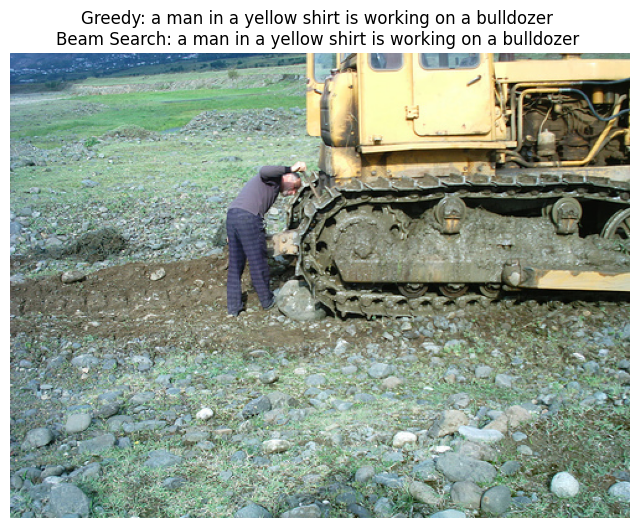

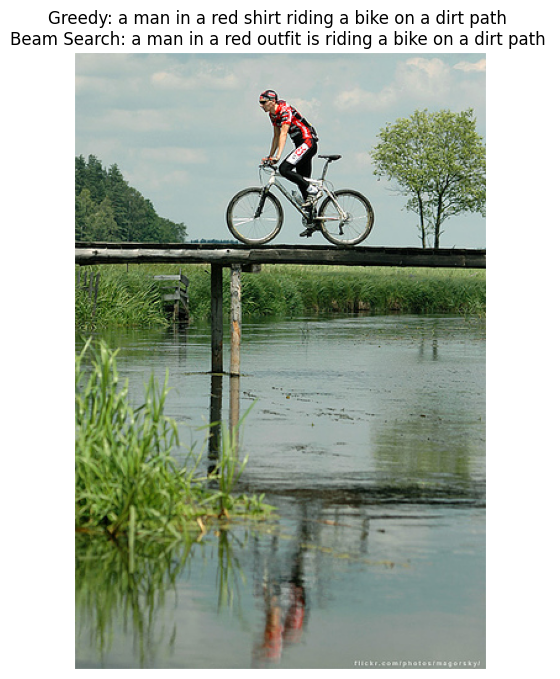

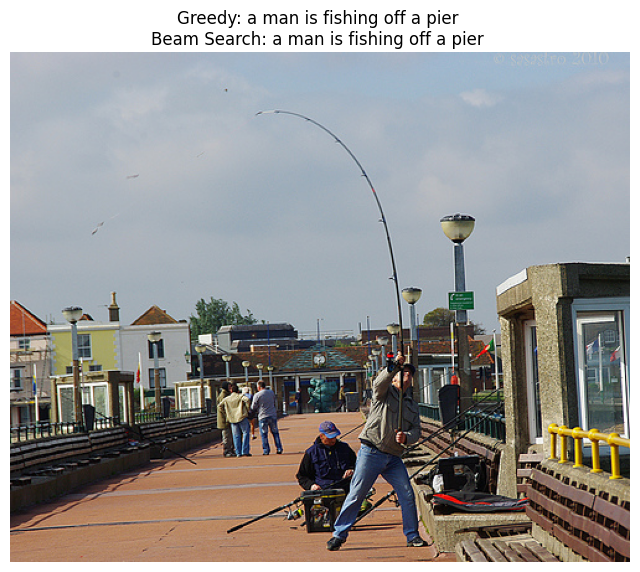

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Display 3 random examples
model.eval()
indices = np.random.randint(0, len(df), 3)

for idx in indices:
    img_name = df.iloc[idx, 0]
    img_path = os.path.join(IMAGE_DIR, img_name)
    image = Image.open(img_path).convert("RGB")
    
    # Preprocess
    img_tensor = transform(image)
    
    # Generate
    greedy_cap = greedy_decode(model, img_tensor, vocab)
    beam_cap = beam_search_decode(model, img_tensor, vocab, beam_width=5)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Greedy: {greedy_cap}\nBeam Search: {beam_cap}")
    plt.axis('off')
    plt.show()

## Quantitative Evaluation

In [54]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_model(model, dataset, vocab):
    model.eval()
    refs = []
    hyps = []
    
    # Use a subset for speed if needed
    indices = range(min(500, len(dataset))) 
    
    print("Evaluating BLEU scores...")
    for idx in tqdm(indices):
        img, caption_tensor = dataset[idx]
        
        # Ground truth
        # caption_tensor includes <start> and <end>
        # Convert to list of words
        gt_caption = [vocab.itos[i.item()] for i in caption_tensor if i.item() not in [0, 1, 2, 3]]
        refs.append([gt_caption])
        
        # Prediction
        pred_caption_str = greedy_decode(model, img, vocab)
        hyps.append(pred_caption_str.split())
        
    bleu1 = 0
    chencherry = SmoothingFunction()
    
    print(f"BLEU-1: {corpus_bleu(refs, hyps, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1):.4f}")
    print(f"BLEU-2: {corpus_bleu(refs, hyps, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1):.4f}")

evaluate_model(model, train_dataset, vocab)

Evaluating BLEU scores...


100%|██████████| 500/500 [00:12<00:00, 41.38it/s]


BLEU-1: 0.3858
BLEU-2: 0.2588
Created dataset file at: .gradio/flagged/dataset1.csv


## Gradio

In [49]:
# Run Gradio inline
import gradio as gr

def gradio_predict(image, method):
    if image is None: return "No image"
    img_tensor = transform(image)
    if method == "Beam Search":
        return beam_search_decode(model, img_tensor, vocab, beam_width=5)
    else:
        return greedy_decode(model, img_tensor, vocab)

iface = gr.Interface(
    fn=gradio_predict,
    inputs=[gr.Image(type="pil"), gr.Radio(["Greedy", "Beam Search"], value="Beam Search")],
    outputs="text",
    title="Neural Storyteller"
)

iface.launch(share=True, inline=False) # inline=False to avoid iframe issues in some envs, or use debug=True

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a626de660c523a8198.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
